In [2]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
N_FACE = 70
N_POSE = 8
FOLDER = './drive/My Drive/636/data/json/'
CSV_FOLDER = './drive/My Drive/636/data/csv/'

In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import time
import csv

Reshape Data into Segments and Prepare for Keras (part5 data)

In [0]:
# dataset = pd.read_csv('./drive/My Drive/636/dataset/part4/dataset.csv')

In [0]:
file_path = './drive/My Drive/636/dataset/part5/dataset_dropped.csv'
dataset = pd.read_csv(file_path)

In [7]:
dataset.head()

,Unnamed: 0,vid,label,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,...,f_116,f_117,f_118,f_119,f_120,f_121,f_122,f_123,f_124,f_125,f_126,f_127,f_128,f_129,f_130,f_131,f_132,f_133,f_134,f_135,f_136,f_137,f_138,f_139,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,p_11,p_12,p_13,p_14,p_15
0,0,12,0,0.321038,0.501176,0.309984,0.691371,0.309984,0.774445,0.329636,0.844402,0.350515,0.903428,0.370167,0.953709,0.389818,0.975571,0.411926,0.975571,0.409469,0.975571,0.607212,0.953709,0.609668,0.975571,0.631776,0.925289,0.655112,0.877194,0.675992,0.807237,0.695643,0.730722,0.709153,0.652021,0.715294,0.571133,0.377536,0.505549,0.410698,...,0.489303,0.975571,0.459826,0.940592,0.440175,0.907800,0.494216,0.934034,0.517552,0.947151,0.538432,0.936220,0.577735,0.931848,0.538432,0.938406,0.517552,0.944965,0.492988,0.938406,0.430349,0.590808,0.630548,0.599553,0.531960,0.756189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,12,0,0.285971,0.550667,0.285971,0.656529,0.283268,0.747954,0.319763,0.827351,0.349501,0.904341,0.373831,0.959678,0.415734,1.000580,0.444120,1.000580,0.506298,1.000580,0.560366,1.000580,0.592806,1.000580,0.622544,0.935618,0.648226,0.873064,0.676611,0.793667,0.694183,0.714271,0.709052,0.630063,0.710404,0.550667,0.372480,0.500142,0.403569,...,0.484671,0.976519,0.460340,0.942836,0.440065,0.899529,0.491429,0.928400,0.513056,0.938024,0.536035,0.935618,0.573882,0.918777,0.536035,0.935618,0.513056,0.938024,0.491429,0.933212,0.426548,0.589162,0.625247,0.591568,0.524355,0.747948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,12,0,0.285893,0.478810,0.281725,0.577716,0.281725,0.691457,0.302563,0.782945,0.337292,0.876906,0.365076,0.946140,0.403972,1.015370,0.434534,1.015370,0.505382,1.015370,0.558170,1.015370,0.588732,0.990647,0.619294,0.933776,0.648466,0.869488,0.672082,0.792836,0.692919,0.711239,0.705422,0.627169,0.708200,0.548044,0.370632,0.496119,0.402583,...,0.483155,0.975811,0.458150,0.946140,0.438702,0.894214,0.490101,0.926359,0.510938,0.931304,0.535943,0.928831,0.572062,0.913995,0.535943,0.931304,0.510938,0.936249,0.490101,0.928831,0.426199,0.577716,0.623461,0.585134,0.519761,0.742567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,12,0,0.312792,0.483795,0.312792,0.399218,0.301827,0.752708,0.314010,0.815598,0.340815,0.884995,0.361527,0.932705,0.382240,0.958729,0.371274,0.934874,0.402952,0.958729,0.605203,0.937043,0.601548,0.958729,0.623479,0.915356,0.645410,0.863309,0.667340,0.793912,0.686834,0.720178,0.703892,0.639938,0.711202,0.568373,0.370056,0.494639,0.401734,...,0.484583,0.958729,0.456561,0.924031,0.438285,0.893670,0.488239,0.917525,0.508951,0.930537,0.533319,0.919694,0.569870,0.913188,0.532100,0.921862,0.510169,0.928368,0.488239,0.919694,0.423665,0.574879,0.623479,0.581385,0.519765,0.734375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,12,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.519762,0.731714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
dataset.shape

(97069, 159)

In [0]:
# get number of features
N_FEATURES = (N_FACE + N_POSE) * 2

In [0]:
# slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
def get_slices(df, index_arr, TIME_STEP):
  slices = []
  for i in index_arr:
    if i + 1 < TIME_STEP:
      slice_ = df.values[df.index[0 : i + 1]]
      fillzero = np.zeros((TIME_STEP - i - 1, N_FEATURES))
      slice_ = np.concatenate((slice_, fillzero), axis=0)
      slices.append(slice_)
    else:
      slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

  slices_arr = np.asarray(slices, dtype= np.float32)
  return slices_arr

In [0]:
def create_segments(df, TIME_STEP):
  # get video id
  vids = df.vid.unique()
  segments = []
  # get segment of each video id
  for i in vids:
    # slice every 10 frame as a segment and use the first label as label of segment
    # get all index of an id
    index_arr = df.index[df['vid'] == i]
    # drop the id and label
    df_s = df[df.columns[3:]]

    if i == vids[0]:
      segments = get_slices(df_s, index_arr, TIME_STEP)
    else:
      # get slices of each person
      segment = get_slices(df_s, index_arr, TIME_STEP)
      # print(i, segment.shape)
      segments = np.concatenate((segments, segment), axis=0)

  return segments

In [0]:
X = create_segments(dataset, 10)

In [0]:
y = dataset['label'].to_numpy()

In [14]:
print(X.shape, y.shape)

(97069, 10, 156) (97069,)


In [15]:
type(X)

numpy.ndarray

In [16]:
type(y)

numpy.ndarray

In [0]:
def save_3d(data):
  # Write the array to disk
  with open('./drive/My Drive/636/dataset/part5/sliced.txt', 'w') as outfile:
      # I'm writing a header here just for the sake of readability
      # Any line starting with "#" will be ignored by numpy.loadtxt
      outfile.write('# Array shape: {0}\n'.format(data.shape))

      # Iterating through a ndimensional array produces slices along
      # the last axis. This is equivalent to data[i,:,:] in this case
      for data_slice in data:

          # The formatting string indicates that I'm writing out
          # the values in left-justified columns 7 characters in width
          # with 2 decimal places.  
          # np.savetxt(outfile, data_slice, fmt='%-7.2f')
          np.savetxt(outfile, data_slice)

          # Writing out a break to indicate different slices...
          outfile.write('# New slice\n')

In [0]:
def read_3d(data):
  # Read the array from disk
  new_data = np.loadtxt('./drive/My Drive/636/dataset/part5/sliced.txt')

  # Note that this returned a 2D array!
  print new_data.shape

  # However, going back to 3D is easy if we know the 
  # original shape of the array
  new_data = new_data.reshape((97069, 50, 156))

  # Just to check that they're the same...
  assert np.all(new_data == data)

In [0]:
save_3d(X)

In [0]:
# vids = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18, 19, 22, 23, 24, 25, 26]
# def concat_csv(vids):
#   df = pd.read_csv(CSV_FOLDER + str(vids[0]) + '.csv')
#   for i in vids[1:]:
#     file_path = CSV_FOLDER + str(i) + '.csv'
#     df1 = pd.read_csv(file_path) 
#     df = pd.concat([df, df1])
#   return df
# dataset = dataset.drop(columns=['Unnamed: 0','frame'])
# dataset.to_csv('./drive/My Drive/636/dataset/part5/dataset_dropped.csv')

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(77655, 10, 156) (19414, 10, 156) (77655,) (19414,)


Build model

In [16]:
%tensorflow_version 1.x
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, LSTM, LSTM, Dropout, Flatten, Bidirectional, Activation
from keras.callbacks import History, EarlyStopping

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
def create_model():
  model = Sequential()
  model.add(Dense(64, activation='relu'))
  model.add(LSTM(64))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [0]:
# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [23]:
model = create_model()
history = model.fit(X_train, y_train, epochs=30, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=2)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 62124 samples, validate on 15531 samples
Epoch 1/30





 - 34s - loss: 0.5498 - acc: 0.7182 - val_loss: 0.4913 - val_acc: 0.7570
Epoch 2/30
 - 25s - loss: 0.4793 - acc: 0.7711 - val_loss: 0.4959 - val_acc: 0.7654
Epoch 3/30
 - 27s - loss: 0.4443 - acc: 0.7927 - val_loss: 0.4235 - val_acc: 0.7940
Epoch 4/30
 - 28s - loss: 0.4167 - acc: 0.8062 - val_loss: 0.4026 - val_acc: 0.8207
Epoch 5/30
 - 28s - loss: 0.3967 - acc: 0.8175 - val_loss: 0.3943 - val_acc: 0.8152
Epoch 6/30
 - 28s - loss: 0.3771 - acc: 0.8284 - val_loss: 0.3829 - val_acc: 0.8218
Epoch 7/30
 - 27s - loss: 0.3601 - acc: 0.8374 - val_loss: 0.3841 - val_acc: 0.8291
Epoch 8/30
 - 28s - loss: 0.3443 - acc: 0.8457 - val_loss: 0.3878 - val_acc: 0.8196
Epoch 9/30
 - 27s - loss: 0.3288 - acc: 0.8546 - val_loss: 0.3438 - val_acc: 0.8455
Epoch 10/30
 - 27s - loss: 0.3163 - acc: 0.8599 - val_loss: 0.3874 - val_acc: 0.8341
Epoc

In [24]:
history1 = model.fit(X_train, y_train, epochs=30, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score1 = model.evaluate(X_test, y_test, verbose=2)

Train on 62124 samples, validate on 15531 samples
Epoch 1/30
 - 28s - loss: 0.1806 - acc: 0.9253 - val_loss: 0.2643 - val_acc: 0.8902
Epoch 2/30
 - 28s - loss: 0.1775 - acc: 0.9266 - val_loss: 0.2174 - val_acc: 0.9057
Epoch 3/30
 - 27s - loss: 0.1755 - acc: 0.9270 - val_loss: 0.1620 - val_acc: 0.9363
Epoch 4/30
 - 28s - loss: 0.1706 - acc: 0.9313 - val_loss: 0.1705 - val_acc: 0.9286
Epoch 5/30
 - 28s - loss: 0.1671 - acc: 0.9314 - val_loss: 0.1929 - val_acc: 0.9147
Epoch 6/30
 - 28s - loss: 0.1637 - acc: 0.9326 - val_loss: 0.1838 - val_acc: 0.9243
Epoch 7/30
 - 27s - loss: 0.1629 - acc: 0.9328 - val_loss: 0.1676 - val_acc: 0.9314
Epoch 8/30
 - 27s - loss: 0.1586 - acc: 0.9349 - val_loss: 0.1902 - val_acc: 0.9255
Epoch 9/30
 - 28s - loss: 0.1559 - acc: 0.9351 - val_loss: 0.2655 - val_acc: 0.8958
Epoch 10/30
 - 28s - loss: 0.1517 - acc: 0.9383 - val_loss: 0.2533 - val_acc: 0.8936
Epoch 11/30
 - 27s - loss: 0.1511 - acc: 0.9390 - val_loss: 0.1878 - val_acc: 0.9221
Epoch 12/30
 - 27s - los

In [25]:
score1

[0.16648457097481587, 0.9330380138351729]

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50, 64)            10048     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 43,137
Trainable params: 43,137
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 10, 32)            24192     
_________________________________________________________________
dense_14 (Dense)             (None, 10, 1)             33        
Total params: 24,225
Trainable params: 24,225
Non-trainable params: 0
_________________________________________________________________


**model 2**

In [0]:
# hyperparameter
TIME_STEP = 10
LSTM_OUTPUT_DIM = 64
BATCH_SIZE = 50
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156

In [0]:
def create_model():
  model = Sequential()
  model.add(Dense(units = LSTM_OUTPUT_DIM, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(LSTM(units = LSTM_OUTPUT_DIM, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(LSTM(units = LSTM_OUTPUT_DIM))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [21]:
# create model
model = create_model()
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=2)

Train on 62124 samples, validate on 15531 samples
Epoch 1/100
 - 46s - loss: 0.5554 - acc: 0.7163 - val_loss: 0.5237 - val_acc: 0.7381
Epoch 2/100
 - 44s - loss: 0.4951 - acc: 0.7631 - val_loss: 0.4964 - val_acc: 0.7598
Epoch 3/100
 - 44s - loss: 0.4606 - acc: 0.7856 - val_loss: 0.4483 - val_acc: 0.7851
Epoch 4/100
 - 45s - loss: 0.4361 - acc: 0.7976 - val_loss: 0.4674 - val_acc: 0.7897
Epoch 5/100
 - 44s - loss: 0.4127 - acc: 0.8096 - val_loss: 0.5667 - val_acc: 0.7368
Epoch 6/100
 - 44s - loss: 0.3954 - acc: 0.8178 - val_loss: 0.3683 - val_acc: 0.8297
Epoch 7/100
 - 43s - loss: 0.3760 - acc: 0.8283 - val_loss: 0.3922 - val_acc: 0.8280
Epoch 8/100
 - 43s - loss: 0.3651 - acc: 0.8335 - val_loss: 0.3409 - val_acc: 0.8486
Epoch 9/100
 - 43s - loss: 0.3528 - acc: 0.8419 - val_loss: 0.3630 - val_acc: 0.8393
Epoch 10/100
 - 42s - loss: 0.3393 - acc: 0.8484 - val_loss: 0.3294 - val_acc: 0.8558
Epoch 11/100
 - 43s - loss: 0.3295 - acc: 0.8533 - val_loss: 0.3465 - val_acc: 0.8332
Epoch 12/100


In [22]:
score

[0.2517325661449387, 0.9050685072750808]

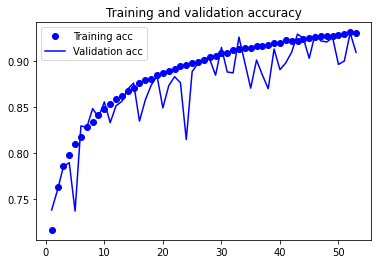

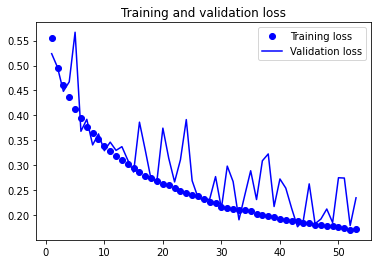

In [25]:
draw(history)

In [0]:
# hyperparameter
TIME_STEP = 10
LSTM_OUTPUT_DIM = 64
BATCH_SIZE = 50
EPOCH = 100
DROPOUT = 0.8
INPUT_DIM = 156

In [0]:
def create_model():
  model = Sequential()
  model.add(Dense(units = LSTM_OUTPUT_DIM, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(LSTM(units = LSTM_OUTPUT_DIM, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(LSTM(units = LSTM_OUTPUT_DIM))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [28]:
# create model
model = create_model()
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10, 64)            10048     
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 76,161
Trainable params: 76,161
Non-trainable params: 0
_________________________________________________________________
Train on 62124 samples, validate on 15531 samples
Epoch 1/100
 - 45s - loss: 0.5679 - acc: 0.7065 - val_loss: 0.5277

save model

In [0]:
MODEL_FOLDER = './drive/My Drive/636/model/'

In [30]:
model.save(MODEL_FOLDER + '2lstm.h5')

OSError: ignored

In [0]:
model.save('2lstm.h5')

draw figure

In [0]:
import matplotlib.pyplot as plt
def draw(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

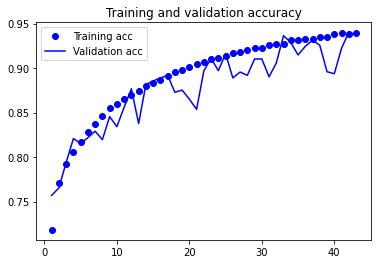

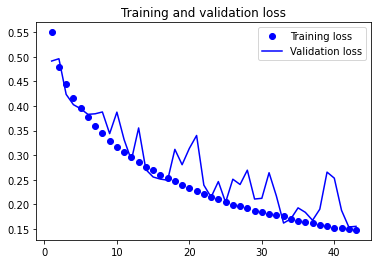

In [28]:
import matplotlib.pyplot as plt

acc = history.history['acc'] + history1.history['acc']
val_acc = history.history['val_acc'] + history1.history['val_acc']
loss = history.history['loss'] + history1.history['loss']
val_loss = history.history['val_loss'] + history1.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()